In [217]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import tree
from sklearn.datasets import load_iris
import graphviz
from typing import Optional, List
import matplotlib.cm as plt_cm
import math

# 决策树和回归树

## 决策树

### 决策树构造
对于[感知机](./perceptron.ipynb)、[逻辑回归](./logistic_regression.ipynb)、[支持向量机](./support_vector_machines.ipynb)以及[朴素贝叶斯](./naive_bayes_classifier.ipynb)，这些分类算法只能给出分类的结果，而不能给出为何这么分类的原因。

决策树(Decision tree)也是一种分类算法，和上述分类算法不同的是，决策树在分类的时候可以给出具体分类的过程，下面就介绍下决策树的具体原理。

决策树是一棵多叉树，每个非叶子节点都是一个特征值，叶子节点是所属类别。下面以一个简单的数据集举例

$$\begin{array}{c|c|c}
    \hline
    \quad 是否有工作\quad &\quad 是否有抵押物\quad &\quad 是否发放贷款\quad\\
    \hline
    有&有&是\\
    有&无&否\\
    无&有&否\\
    无&无&否\\
    \hline
\end{array}$$

通过数据集$D$得到上图所示的树状结构就称为决策树，当需要预测新的特征向量$(x_1, x_2)$是否应该发放贷款时，根据该决策树就能够判断出对应的类别了。

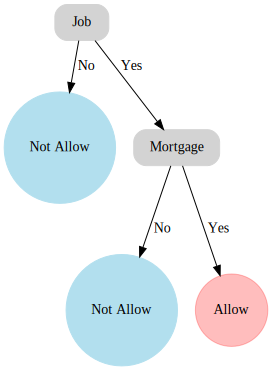

In [218]:
def majority_rule(fn):
    def wrapper(y: np.ndarray):
        yy = np.unique(y)
        majority_y = None
        cnt = 0
        for cl in yy:
            curr = (y[y==cl]).shape[0]
            if curr > cnt:
                cnt = curr
                majority_y = cl
        return fn(majority_y)
    return wrapper

class TreeNode:
    children = None
    samples = 0
    value = ""
    gini = 0
    edge_labels = []
    color = "lightgrey"
    feature: int
    target: int
    op = None
    fmt = False
    category_info = None

    def __init__(self, value="", samples=0, edge_labels = "", 
                 children = None, color = None, feature = None, 
                 target = None, op = None, gini = None, fmt=False, 
                 category_info = None, regression=False):
        self.children = children
        self.samples = samples
        self.value = value
        self.edge_labels = edge_labels
        if color:
            self.color = color
        if gini:
            self.gini = gini
        self.feature = feature
        self.target = target
        self.op = op
        self.fmt = fmt
        self.category_info = category_info
        self.regression = regression
    
    def __str__(self):
        if not self.fmt:
            return self.value
        gini = "gini"
        value = self.value
        if self.regression:
            gini = "err"
            if not self.children:
                value = None
        if value:
            return r"{}\n{}={:.2f}\nsamples={}\nvalue={}".format(self.value, gini, self.gini, self.samples, self.category_info)
        else:
            return r"{}={:.2f}\nsamples={}\nvalue={}".format(gini, self.gini, self.samples, self.category_info)

class DecisionTree:
    feature_names_ = None
    feature_value_names_ = None 
    target_names_ = None
    target_colors_ = None
    target_ = None
    n_target_ = None
    target_start_val_ = None
    alpha_ = None
    beta_ = None
    regression_ = False

    def __init__(self, X: np.ndarray, y: np.ndarray, feature_names, 
                 feature_value_names, target_names, target_colors, target, **kwargs):
        self.feature_names_ = feature_names
        self.feature_value_names_ = feature_value_names
        self.target_names_ = target_names
        self.target_colors_ = target_colors
        self.node_start = kwargs.pop("node_start") if "node_start" in kwargs else 0
        self.fmt = kwargs.pop("fmt") if "fmt" in kwargs else False
        self.alpha_ = kwargs.pop("alpha") if "alpha" in kwargs else None
        self.beta_ = kwargs.pop("beta") if "beta" in kwargs else None
        self.target_ = target
        self.regression_ = kwargs.pop("regression") if "regression" in kwargs else False
        if not self.regression_:
            self.n_target_ = np.unique(y).shape[0]
            self.target_start_val_ = y.min()
        self.root = self._recurse(X, y, **kwargs)

    def _gini_two_classification(self, p):
        return 2 * p * (1 - p)

    def _gini(self, y: np.ndarray):
        total = y.shape[0]
        gini = 1
        for cl in np.unique(y):
            yy = y[y==cl]
            # print(yy.shape[0], y.shape[0])
            gini -= math.pow(yy.shape[0] / total, 2)
        return gini

    def _split_by_feature(self, X: np.ndarray, y: np.ndarray, feature: int):
        """ 
        only classification
        split train set into n datasets, n is unique(X[:, feature])
        return
            List[Tuple[feat, x, y]]: all samples in x have feat value of feature
        """
        xx = X[:, feature]
        unique_xx = np.unique(xx)
        if unique_xx.shape[0] < 2:
            return None
        ans = []
        for feat in unique_xx:
            split_X, split_y = X[xx==feat], y[xx==feat]
            ans.append((feat, split_X, split_y))
        return ans

    def _split_use_gini(self, X: np.ndarray, y: np.ndarray):
        """ 
        only classification
        try the feature which has minimum gini index as key to split train set
        return 
            feature: split train set by this feature
            List[Tuple[feat, x, y]]: all samples in x have feat value of feature
        """
        n_feature = X.shape[1]
        best_gini = 2
        best_ans = None
        best_feature = None
        for i in range(n_feature):
            ans = self._split_by_feature(X, y, i)
            if not ans:
                continue
            gini = 0
            for xy in ans:
                _, xx, yy = xy
                gini += yy.shape[0] / y.shape[0] * self._gini(yy)
            if gini < best_gini:
                best_gini = gini
                best_ans = ans
                best_feature = i
        return best_feature, best_ans
    
    def _split_by_cart(self, X: np.ndarray, y: np.ndarray):
        """ 
        use cart to split train set into two datasets
        """
        n_features = X.shape[1]
        n_samples = X.shape[0]
        best_gini = None
        best_ans = None
        best_feature = None
        for i in range(n_features):
            x_feature = X[:, i]
            x_feature_sort = np.sort(x_feature)
            if x_feature_sort[0] == x_feature_sort[-1]:
                continue
            ans = []
            for j in range(n_samples - 1):
                gini = 0
                mid = (x_feature_sort[j] + x_feature_sort[j + 1]) / 2
                xx_left, xx_right, yy_left, yy_right = X[x_feature <= mid], X[x_feature > mid], \
                    y[x_feature <= mid], y[x_feature > mid]
                ans = []
                ans.append((mid, xx_left, yy_left))
                ans.append((mid, xx_right, yy_right))
                for yy in (yy_left, yy_right):
                    if not self.regression_:
                        gini += yy.shape[0] / y.shape[0] * self._gini(yy)
                    else:
                        gini += self._gini(yy)
                if best_gini == None or gini < best_gini:
                    best_gini = gini
                    best_feature = i
                    best_ans = ans
        return best_feature, best_ans

    def _recurse(self, X: np.ndarray, y: np.ndarray, **kwargs):
        # print("recurse: ", X.shape, y.shape)
        order = kwargs.pop("order") if "order" in kwargs else None
        use_gini = kwargs.pop("gini") if "gini" in kwargs else False
        cart = kwargs.pop("cart") if "cart" in kwargs else False
        n_samples = X.shape[0]
        n_target = np.unique(y).shape[0]
        if n_target == 1:
            category_info = None
            if self.regression_:
                category_info = f"{np.mean(y):.3f}"
            else:
                category_info = np.zeros(self.n_target_, dtype=int)
                category_info[y[0] - self.target_start_val_] = n_samples
            root = TreeNode(value=self.target_names_(y), samples=n_samples, 
                            color=self.target_colors_(y), target=self.target_(y), fmt=self.fmt, 
                            category_info=category_info, regression=self.regression_)
            return root
        
        # gini = self._gini_two_classification((y[y==1]).shape[0] / n_samples)
        gini = self._gini(y) 
        if (use_gini or cart) and self.alpha_ != None and gini < self.alpha_:
            category_info = None
            if self.regression_:
                category_info = f"{np.mean(y):.3f}"
            else:
                category_info = np.zeros(self.n_target_, dtype=int)
                for cl in np.unique(y):
                    category_info[cl - self.target_start_val_] = (y[y==cl]).shape[0]
            root = TreeNode(value=self.target_names_(y), samples=n_samples, 
                            color=self.target_colors_(y), target=self.target_(y), fmt=self.fmt, 
                            category_info=category_info, gini=gini, regression=self.regression_)
            return root
        
        if order:
            assert not use_gini
            ans = None
            for feature in order:
                ans = self._split_by_feature(X, y, feature)
                if ans:
                    break
        elif not cart:
            assert use_gini
            feature, ans = self._split_use_gini(X, y)
        else:
            assert cart
            feature, ans = self._split_by_cart(X, y)
        if not ans:
            category_info = None
            if self.regression_:
                category_info = f"{np.mean(y):.3f}"
            else:
                category_info = np.zeros(self.n_target_, dtype=int)
                for cl in np.unique(y):
                    category_info[cl - self.target_start_val_] = (y[y==cl]).shape[0]
            root = TreeNode(value=self.target_names_(y), samples=n_samples, 
                            color=self.target_colors_(y), target=self.target_(y), fmt=self.fmt, 
                            category_info=category_info, gini=gini, regression=self.regression_)
            return root
        
        gini_son = 0
        for xy in ans:
            _, _, yy = xy
            gini_son += yy.shape[0] / n_samples * self._gini(yy)
        
        if (use_gini or cart) and self.beta_ != None and abs(gini_son - gini) < self.beta_:
            category_info = None
            if self.regression_:
                category_info = f"{np.mean(y):.3f}"
            else:
                category_info = np.zeros(self.n_target_, dtype=int)
                for cl in np.unique(y):
                    category_info[cl - self.target_start_val_] = (y[y==cl]).shape[0]
            root = TreeNode(value=self.target_names_(y), samples=n_samples, 
                            color=self.target_colors_(y), target=self.target_(y), fmt=self.fmt, 
                            category_info=category_info, gini=gini, regression=self.regression_)
            return root

        children = []
        edge_labels = []
        d = {}
        idx = 0
        for xy in ans:
            feat, xx, yy = xy
            child = self._recurse(xx, yy, order=order, gini=use_gini, cart=cart)
            children.append(child)
            edge_labels.append(self.feature_value_names_(feature, feat, idx=idx))
            idx += 1
            d.update({feat: child})
        def op(f):
            return d[f]
        def cart_op(f):
            if f < feat:
                return children[0]
            else:
                return children[1]
        op_ = cart_op if cart else op
        category_info = None
        if self.regression_:
            category_info = f"{np.mean(y):.3f}"
        else:
            category_info = np.zeros(self.n_target_, dtype=int)
            for cl in np.unique(y):
                category_info[cl - self.target_start_val_] = (y[y==cl]).shape[0]
        root = TreeNode(value=self.feature_names_(feature, feat=feat), samples=n_samples, 
                        edge_labels=edge_labels, children=children, feature=feature, 
                        op=op_, gini=gini, fmt=self.fmt, category_info=category_info, regression=self.regression_)
        return root
        
    def plot_tree(self, G: graphviz.Digraph) -> int:
        return self._plot_tree(G, self.root, None, self.node_start)

    def _plot_tree(self, G: graphviz.Digraph, root: Optional[TreeNode], 
                   parent: Optional[int], node_id: int, edge_label = ""):
        if not root:
            return 0
        shape = "Mrecord"
        if not root.children:
            shape = "circle"
        # print("add node:", root.value, shape, root.color, node_id)
        G.node(str(node_id), label=str(root), style="filled", shape=shape, color=root.color)
        if parent != None:
            # print("add edge:", parent, node_id, edge_label)
            G.edge(str(parent), str(node_id), label=edge_label)
        if not root.children:
            return 1
        ret = 1
        for i in range(len(root.children)):
            child = root.children[i]
            ret += self._plot_tree(G, child, node_id, node_id + ret, root.edge_labels[i])
        return ret
        
    
    def predict(self, X: np.ndarray):
        return self._predict(X, self.root)

    def _predict(self, X: np.ndarray, root: TreeNode):
        if not root.children:
            return (root.target, self.target_names_(root.target))
        child = root.op(X[root.feature])
        return self._predict(X, child)

X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]])
y = np.array([1, 0, 0, 0])
feature_names = np.array(["Job", "Mortgage"])
feature_value_names = np.array([["No", "Yes"], ["No", "Yes"]])
target_names = np.array(["Not Allow", "Allow"])
target_colors = np.array(["lightblue2", "#ff000042"])

def get_feature_name(feature, **kwargs):
    return feature_names[feature]

def get_feature_value_name(feat, feat_val, **kwargs):
    return feature_value_names[feat][feat_val]

@majority_rule
def get_target_name(target):
    return target_names[target]

@majority_rule
def get_target_color(target):
    return target_colors[target]

@majority_rule
def get_target(target):
    return target 

decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, order=[0, 1])
G = graphviz.Digraph()
decision_tree.plot_tree(G)
G

In [219]:
feature = np.array([1, 0])
print(f"{feature} is {decision_tree.predict(feature)}")

[1 0] is (0, 'Not Allow')


稍微改下数据集，将“抵押物”改成种类，数据集如下

$$\begin{array}{c|c|c}
    \hline
    \quad是否有工作\quad&\quad抵押物\quad&\quad是否发放贷款\quad\\
    \hline
    有&无&否\\
    有&房产&是\\
    有&股票&是\\
    无&无&否\\
    无&房产&是\\
    无&股票&否\\
    \hline
\end{array}$$

在新的数据集下重新构造决策树

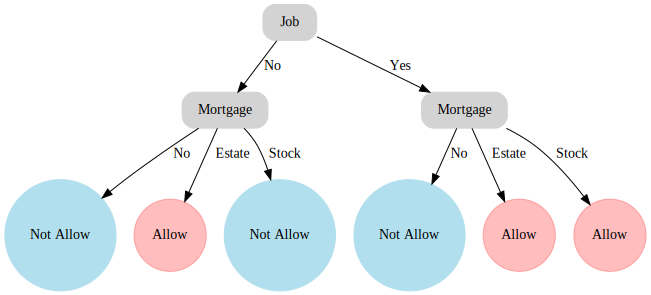

In [220]:
X = np.array([[1, 0], [1, 1], [1, 2], [0, 0], [0, 1], [0, 2]])
y = np.array([0, 1, 1, 0, 1, 0])
feature_value_names = np.array([["No", "Yes", ""], ["No", "Estate", "Stock"]])

def get_feature_value_name(feat, feat_val, **kwargs):
    return feature_value_names[feat][feat_val]

G = graphviz.Digraph()

decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, order=[0, 1])
decision_tree.plot_tree(G)
G

也可以先以特征抵押物分类来构造决策树，那么决策树如下，和上面先以特征是否有工作来分类，决策树分支少了很多。

通过控制决策树的特征和层数，可以得到不同的决策树，需要有一种可量化的评价标准，下面我们讨论下具体如何评价决策树的复杂度。

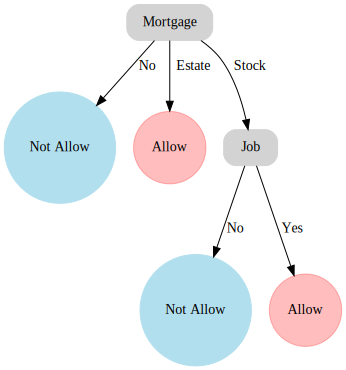

In [221]:
G = graphviz.Digraph()

decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, order=[1, 0])
decision_tree.plot_tree(G)
G

决策树的构造是先根据某个特征，将数据集分成多个不重叠的子集，针对上面的数据集看下决策树的构造过程。

先以“是否有工作”特征将数据集分成两个部分，那么现在有两个更小的数据集了，分别是有工作的一半和没有工作的一半，接着分别对两个子集按照“是否有抵押物”分成三个子集，分别是“无抵押物”、“房产”和“股票”，最后由于每个子集都只有一种类别就不需要再分了，那么就完成了决策树的构造。

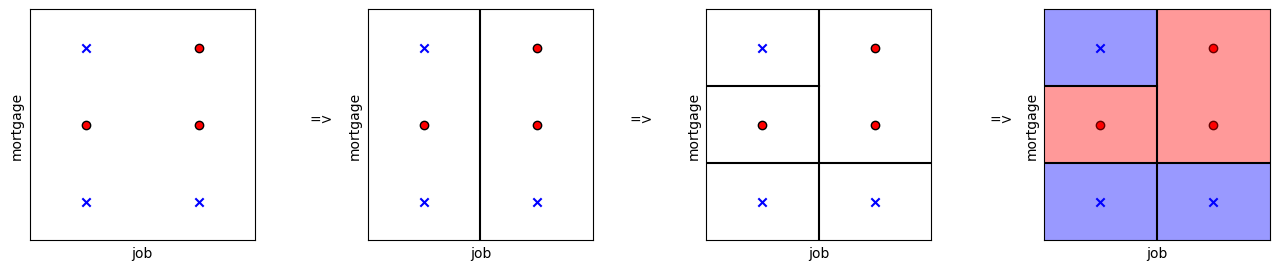

In [222]:
fig, axes = plt.subplots(figsize=(16, 3), ncols=4, nrows=1)
fig.subplots_adjust(wspace=0.5)
markers = ('x', 'o')
colors=("blue", "red")

for cl, m, color in zip(np.unique(y), markers, colors):
    edgecolors='k'
    if m == 'x':
        edgecolors = None
    for ax in axes:
        ax.set(xticks=[], yticks=[])
        ax.set_xlabel("job")
        ax.set_ylabel("mortgage")
        ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=1, c=color, 
               edgecolors=edgecolors, marker=m)
        xx, yy = np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 2.5, 100)
        xx, yy = np.meshgrid(xx, yy)
        Z = np.zeros(xx.shape)
        ax.contour(xx, yy, Z, levels=1)
for ax in axes[1:]:
    ax.plot([0.5, 0.5], [-0.5, 2.5], color='k')

for ax in axes[2:]:
    ax.plot([-0.5, 1.5], [0.5, 0.5], color='k')
    ax.plot([-0.5, 0.5], [1.5, 1.5], color='k')

x_ = [(-0.5, 1.5), (-0.5, 1.5), (-0.5, 0.5), (0.5, 1.5)]
y_ = [(-0.5, 0.5), (0.5, 1.5), (1.5, 2.5), (1.5, 2.5)]
color_ = ["blue", "red", "blue", "red"]

for xl, yl, c in zip(x_, y_, color_):
    xx, yy = np.linspace(xl[0], xl[1], 100), np.linspace(yl[0], yl[1], 100)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(xx.shape)
    axes[3].contourf(xx, yy, Z, colors=c, alpha=0.4)
fig.text(0.3, 0.5, "=>")
fig.text(0.5, 0.5, "=>")
fig.text(0.725, 0.5, "=>")
plt.show()

先根据“抵押物”来划分数据集，再根据“是否有工作”划分数据集，下面就是决策树的构造过程。

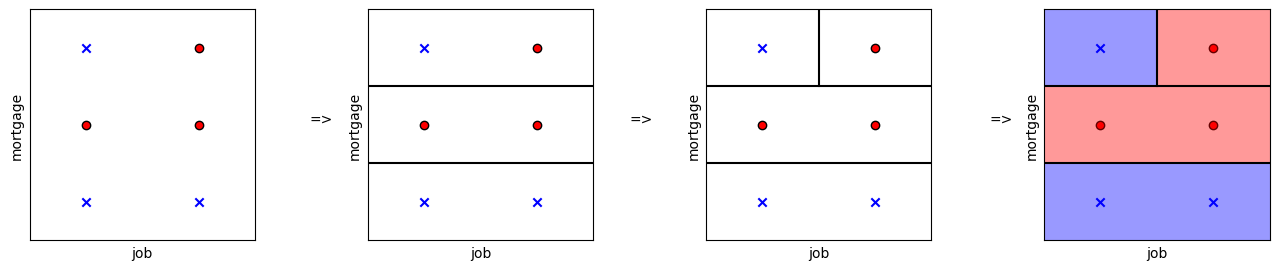

In [223]:
fig, axes = plt.subplots(figsize=(16, 3), ncols=4, nrows=1)
fig.subplots_adjust(wspace=0.5)
markers = ('x', 'o')
colors=("blue", "red")

for cl, m, color in zip(np.unique(y), markers, colors):
    edgecolors='k'
    if m == 'x':
        edgecolors = None
    for ax in axes:
        ax.set(xticks=[], yticks=[])
        ax.set_xlabel("job")
        ax.set_ylabel("mortgage")
        ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=1, c=color, 
               edgecolors=edgecolors, marker=m)
        xx, yy = np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 2.5, 100)
        xx, yy = np.meshgrid(xx, yy)
        Z = np.zeros(xx.shape)
        ax.contour(xx, yy, Z, levels=1)

for ax in axes[1:]:
    ax.plot([-0.5, 1.5], [0.5, 0.5], color='k')
    ax.plot([-0.5, 1.5], [1.5, 1.5], color='k')

for ax in axes[2:]:
    ax.plot([0.5, 0.5], [1.5, 2.5], color='k')

x_ = [(-0.5, 1.5), (-0.5, 1.5), (-0.5, 0.5), (0.5, 1.5)]
y_ = [(-0.5, 0.5), (0.5, 1.5), (1.5, 2.5), (1.5, 2.5)]
color_ = ["blue", "red", "blue", "red"]

for xl, yl, c in zip(x_, y_, color_):
    xx, yy = np.linspace(xl[0], xl[1], 100), np.linspace(yl[0], yl[1], 100)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(xx.shape)
    axes[3].contourf(xx, yy, Z, colors=c, alpha=0.4)
fig.text(0.3, 0.5, "=>")
fig.text(0.5, 0.5, "=>")
fig.text(0.725, 0.5, "=>")

plt.show()

### 基尼系数

上面决策树的构造是根据不同的特征选择将数据集$D$分成多个子集，在子集上继续构造决策树，直到子集中所有样本都属于一个类别后就停止构造。

因此特征的选择是非常关键的，会影响决策树的复杂度（分支数量），决策树的评价标准有多个，这里我们介绍下比较简单的基尼函数。在数学中有一个函数，称为基尼系数(Gini index):

$$Gini(p)=2p(1-p), 0 \le p \le 1$$

基尼系数在$p=0.5$时取得最大值0.5，而$p=0$或者$p=1$时基尼系数取的最小为0。

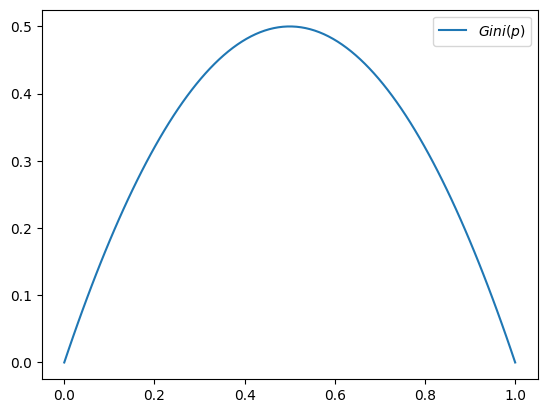

In [224]:
x = np.linspace(0, 1, 100)

ax = plt.subplot()
ax.plot(x, 2*x*(1-x), label="$Gini(p)$")
ax.legend()
plt.show()

在拆分数据集时利用基尼系数的特性，其中$p$代表子集中正类的概率，根据不同的特征划分数据集$D$时，可以计算每种划分的基尼系数：

$$Gini=\sum_{i}^{n}\frac{||D_i||}{||D||}Gini(\frac{||D_{i1}||}{||D_i||})$$

其中$D_i$表示划分的第$i$的子集，$D_{i1}$表示第$i$个子集中正类的集合。

如下，初始数据集中样本数量为6，当使用特征“是否有工作”划分数据集时，得到的基尼系数为
$$Gini=\frac{3}{6}\times 0.44 + \frac{3}{6}\times 0.44 = 0.44$$

当使用“抵押物”划分数据集时，得到的基尼系数为
$$Gini=\frac{2}{6} \times 0 + \frac{2}{6} \times 0 + \frac{2}{6} \times 0.5 = 0.15$$

后者基尼系数更小，因此使用后者的划分方式。

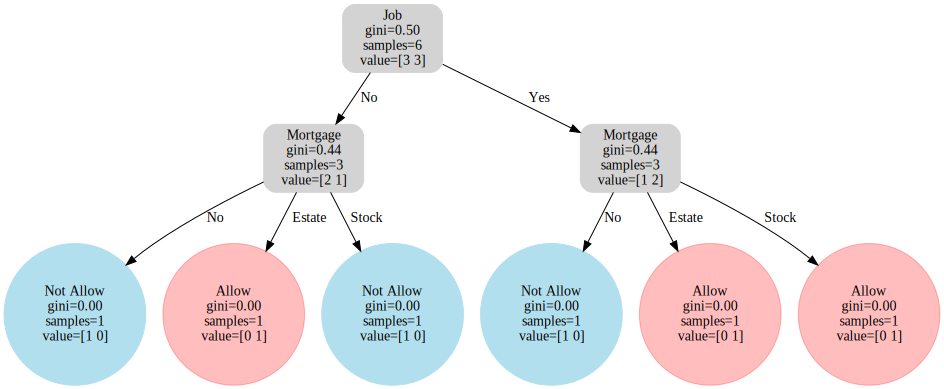

In [225]:
G = graphviz.Digraph()

decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, order=[0, 1], fmt=True)
decision_tree.plot_tree(G)
G

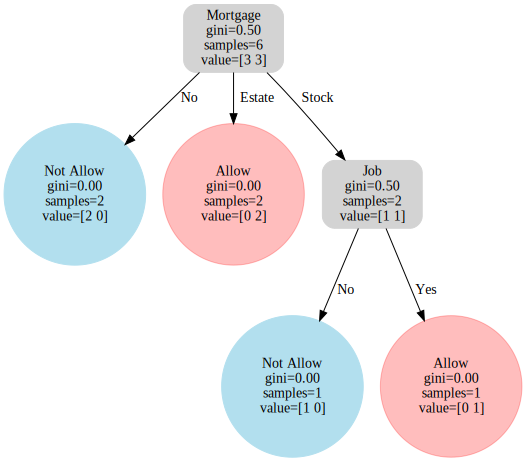

In [226]:
G = graphviz.Digraph()
decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, order=[1, 0], fmt=True)
decision_tree.plot_tree(G)
G

给`DecisionTree`的`__init__`方法中添加`gini`参数代替前面的`order`参数，通过选择最小的基尼系数自动完成数据集的切分。

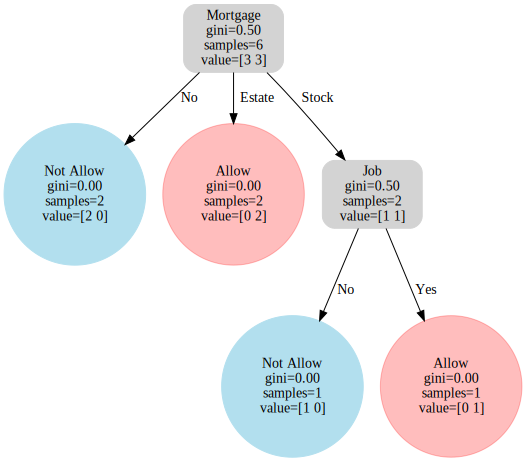

In [227]:
G = graphviz.Digraph()
decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, gini=True, fmt=True)
decision_tree.plot_tree(G)
G

### CART算法
上面我们都是在离散的特征上讨论如何构造决策树的，对于连续的特征需要使用CART算法(Classification And Regression Tree)来划分数据集。

CART算法步骤如下：

- 选择数据集$D$中的某个特征，并且将所有样本该特征的值都提取出来排序
- 以相邻两个值的中点为切分点，将数据集分成两个部分
- 计算两部分的基尼系数，并计算加权平均的基尼系数作为该中点的基尼系数
- 重复步骤2、3，直到该特征所有值的中点都计算完毕，其中基尼系数最小的中点作为该特征的最佳切分点
- 遍历其他特征，重复步骤1、2、3、4，找到基尼系数最小的特征及其最佳切分点作为划分数据集的策略

特别地，CART算法不仅能够用于连续的特征，也可以用于离散的特征，比如下面的例子，数据集即包含连续特征（“年薪”）,也包含离散的特征（“抵押物”）。

将上面数据集中的“是否有工作”改为年薪，并且再`DecisionTree`的`__init__`方法中新增`cart`参数表示是否使用CART算法自动切分数据集。

$$\begin{array}{cc|c}\hline\quad年薪（万）\quad&\quad抵押物\quad&\quad是否发放贷款\quad\\\hline
10&0&否\\
11&1&是\\
12&2&是\\
9&0&否\\
13&1&是\\
8&2&否\\\hline
\end{array}$$

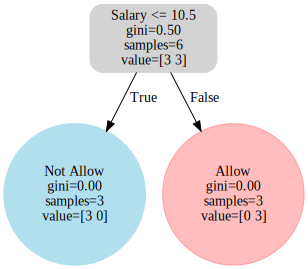

In [228]:
X = np.array([[10, 0], [11, 1], [12, 2], [9, 0], [13, 1], [8, 2]])
y = np.array([0, 1, 1, 0, 1, 0])
feature_names = np.array(["Salary", "Mortgage"])

def get_feature_name(feature, **kwargs):
    feat_val = kwargs.pop("feat")
    if feature == 0:
        return f"{feature_names[0]} \<= {feat_val}"
    else:
        return feature_names[feature]
    
def get_feature_value_name(feat, feat_val, **kwargs):
    idx = kwargs.pop("idx")
    if feat == 0:
        return "True" if idx == 0 else "False"
    else:
        return feature_value_names[feat][idx]

decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, cart=True, fmt=True)
G = graphviz.Digraph()
decision_tree.plot_tree(G)
G

In [229]:
feature = np.array([6, 1])
print(f"{feature_names[0]}={feature[0]}, {feature_names[1]}={feature_value_names[1][feature[1]]} "
      f"is {decision_tree.predict(feature)}")

Salary=6, Mortgage=Estate is (0, 'Not Allow')


### 多分类
上面一直是在二分类场景下的讨论，决策树也可以用于多分类。

安德森鸢尾花卉数据集包含三种类别，四维特征向量，为了方便可视化，支取前面两维特征，数据集如下

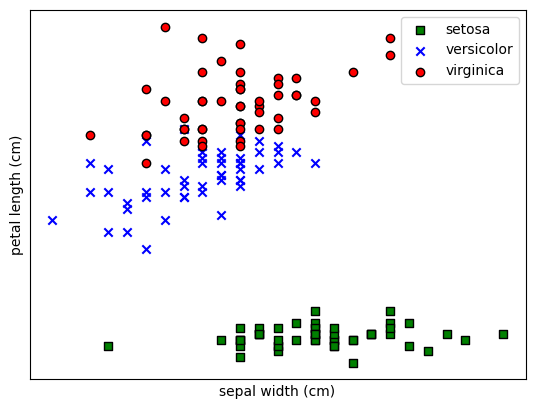

In [241]:
iris = load_iris()
X, y = iris.data, iris.target
X = X[:, [1, 2]]

ax = plt.subplot()
ax.set(xticks=[], yticks=[])
ax.set_xlabel(iris.feature_names[1])
ax.set_ylabel(iris.feature_names[2])
markers = ('s', 'x', 'o')
colors = ("green", "blue", "red")

for cl, m, c in zip(np.unique(y), markers, colors):
    edgecolors = 'k'
    if m == 'x':
        edgecolors = None
    ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=1, c=c, 
               edgecolors=edgecolors, marker=m, label=iris.target_names[cl])
ax.legend()
plt.show()

### 更一般的基尼系数

前面介绍的基尼系数

$$Gini(p)=2p(1-p)$$

只能用于二分类，其中$p$是其中一个类别的比例。多分类的情况需要将基尼系数改写为

$$Gini(p)=\sum_{i}p_i(1-p_i)=1-\sum_{i}p_i^2$$

其中$p_i$是各个类别的占比，这是基尼系数的一般形式。

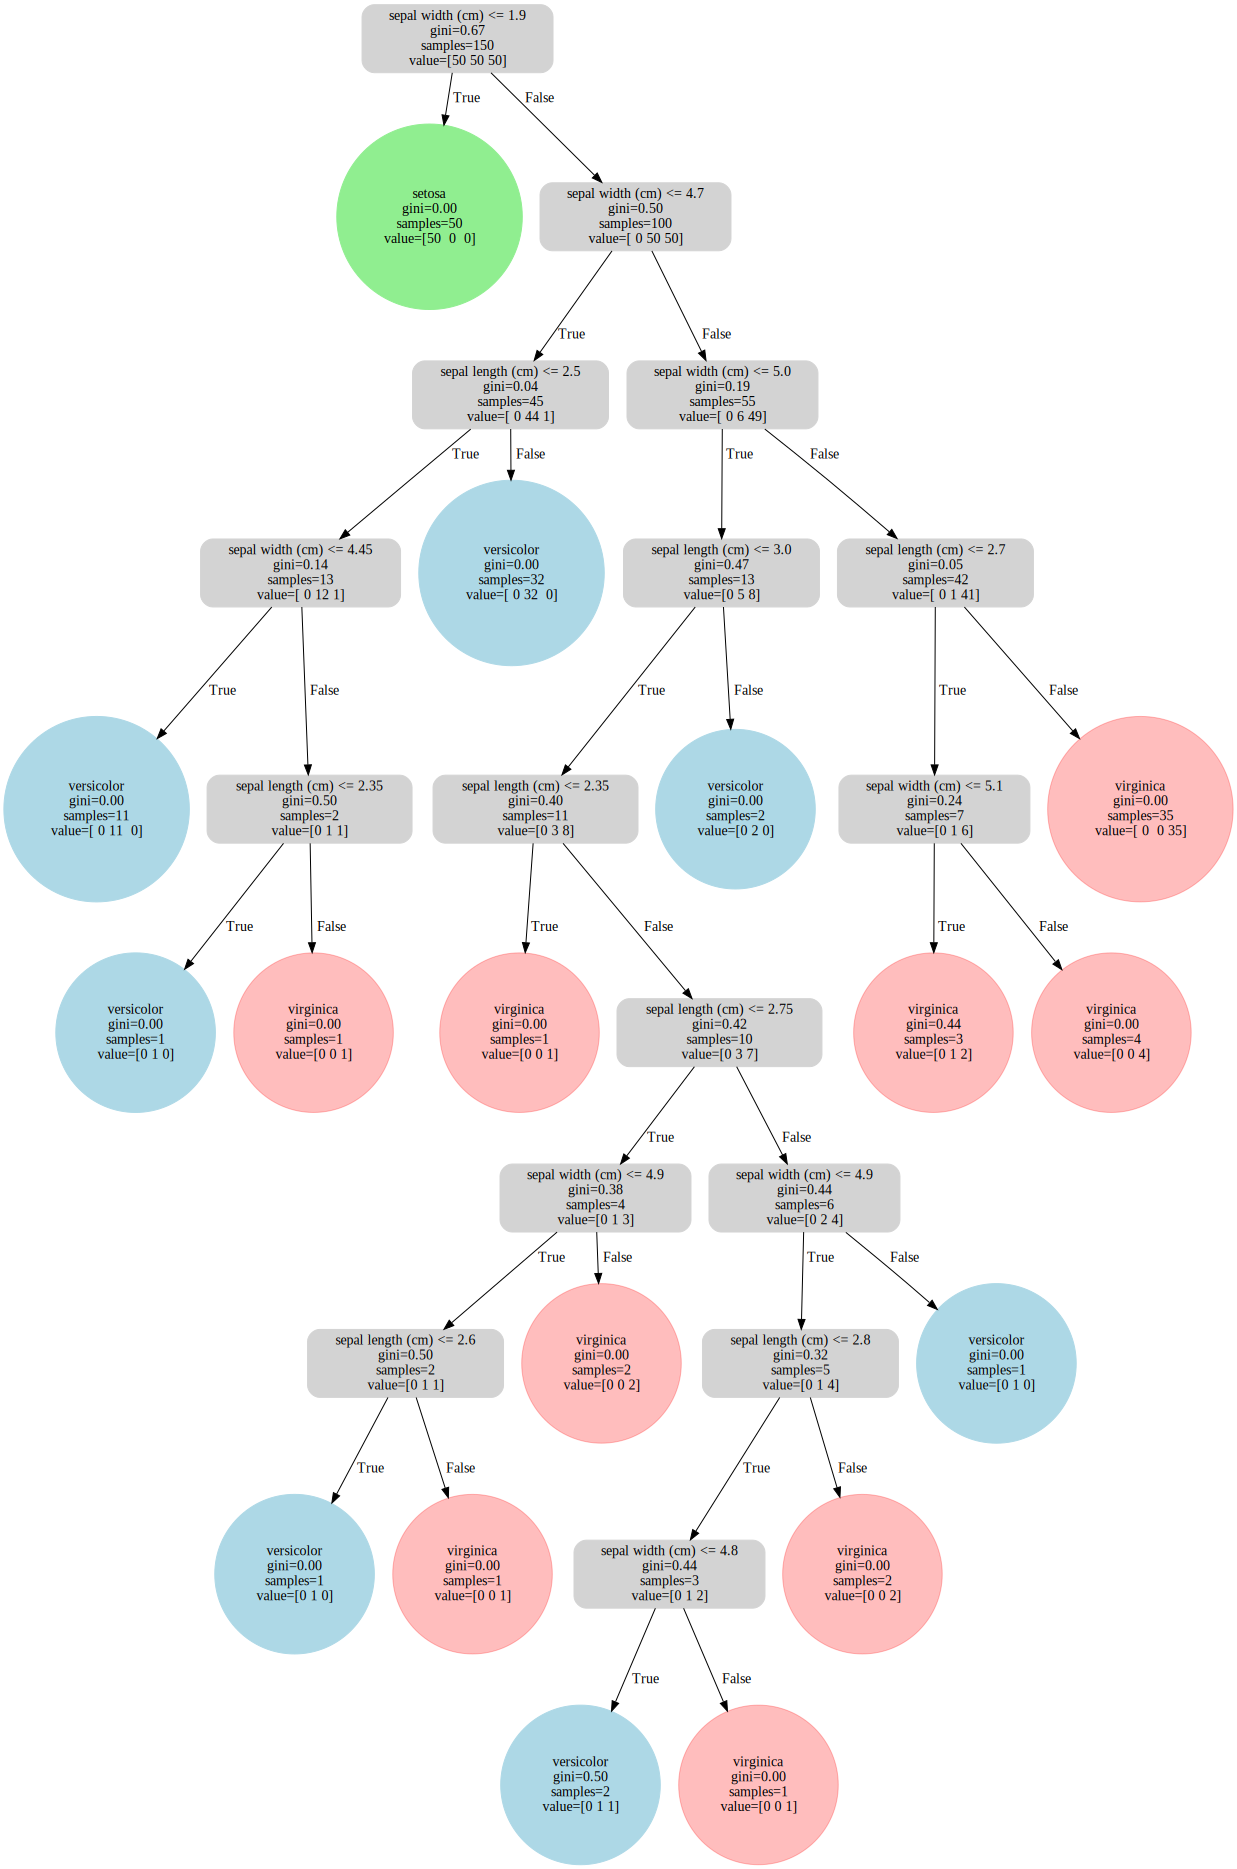

In [242]:
def get_feature_name(feature, **kwargs):
    feat_val = kwargs.pop("feat")
    return f"{iris.feature_names[feature]} \<= {feat_val}"

def get_feature_value_name(feat, feat_val, **kwargs):
    idx = kwargs.pop("idx")
    if idx == 0:
        return "True"
    return "False"

@majority_rule
def get_target_name(target):
    return iris.target_names[target]

@majority_rule
def get_target_color(target):
    colors = ("lightgreen", "lightblue", "#ff000042")
    return colors[target]

@majority_rule
def get_target(target):
    return target 

decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, cart=True, fmt=True)
G = graphviz.Digraph()
decision_tree.plot_tree(G)
G

上面根据安德森鸢尾花卉数据集构造的决策树，总共包含10层，有
$$2 \times 2 \times 4 \times 6 \times 6 \times 2 \times 4 \times 4 \times2 = 36864$$
个分支，其决策边界已经过于弯曲，说明模型过于复杂，产生过拟合的问题了，下面我们在此基础上讨论如何降低决策树的复杂度。

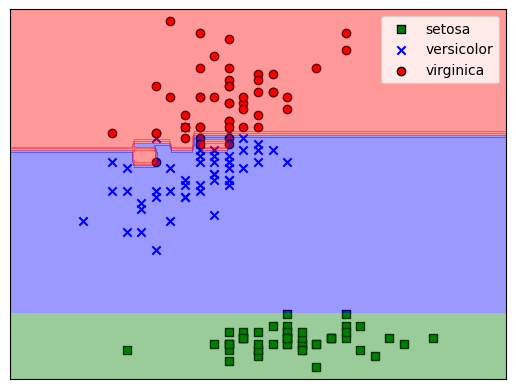

In [232]:
ax = plt.subplot()
ax = plt.subplot()
ax.set(xticks=[], yticks=[])
markers = ('s', 'x', 'o')
colors = ("green", "blue", "red")
for cl, m, c in zip(np.unique(y), markers, colors):
    edgecolors = 'k'
    if m == 'x':
        edgecolors = None
    ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=1, c=c, 
               edgecolors=edgecolors, marker=m, label=iris.target_names[cl])
ax.legend()
x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_min, x1_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 200), np.linspace(x1_min, x1_max))
xy = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([decision_tree.predict(feature)[0] for feature in np.c_[xx.ravel(), yy.ravel()]]).reshape(xx.shape)
cm = ListedColormap(colors)
ax.contourf(xx, yy, Z, cmap=cm, alpha=0.4)
plt.show()

### 决策树的剪枝
决策树的复杂度和层数息息相关，因此通过调节层数来调节模型的复杂度。

在数据结构中，对于需要DFS解决的问题，可以通过剪枝(pruning)来减少需要递归的次数，决策树控制层数也是通过剪枝来完成。决策树的剪枝包含两种策略：预剪枝(Pre-Pruning)和后剪枝(Post-Pruning)。

#### 预剪枝
在构造决策树时，树中的每个节点的基尼系数都大于等于0，而基尼系数表示该节点的错误，比如对于二分类问题，如果$Gini=0.5$，表示数据集中一半是正类一半是负类，此时错误率最高，当需要预测某个新的特征向量$\boldsymbol{x}$的类别时，会有$50\%$的错误率。

可以引入超参数$\alpha$，当节点的基尼系数低于$\alpha$时就停止划分，按照多数原则将设置节点的类别。

在`DecisionTree`的`__init__`方法添加`alpha`参数，设置$\alpha=0.2$，得到的决策树如下，尽管树的层数没有降低，但是分支数量降低到2048个，说明模型复杂度已经降低，如果觉得层数过高，还可以通过增加$\alpha$来进一步降低复杂度。

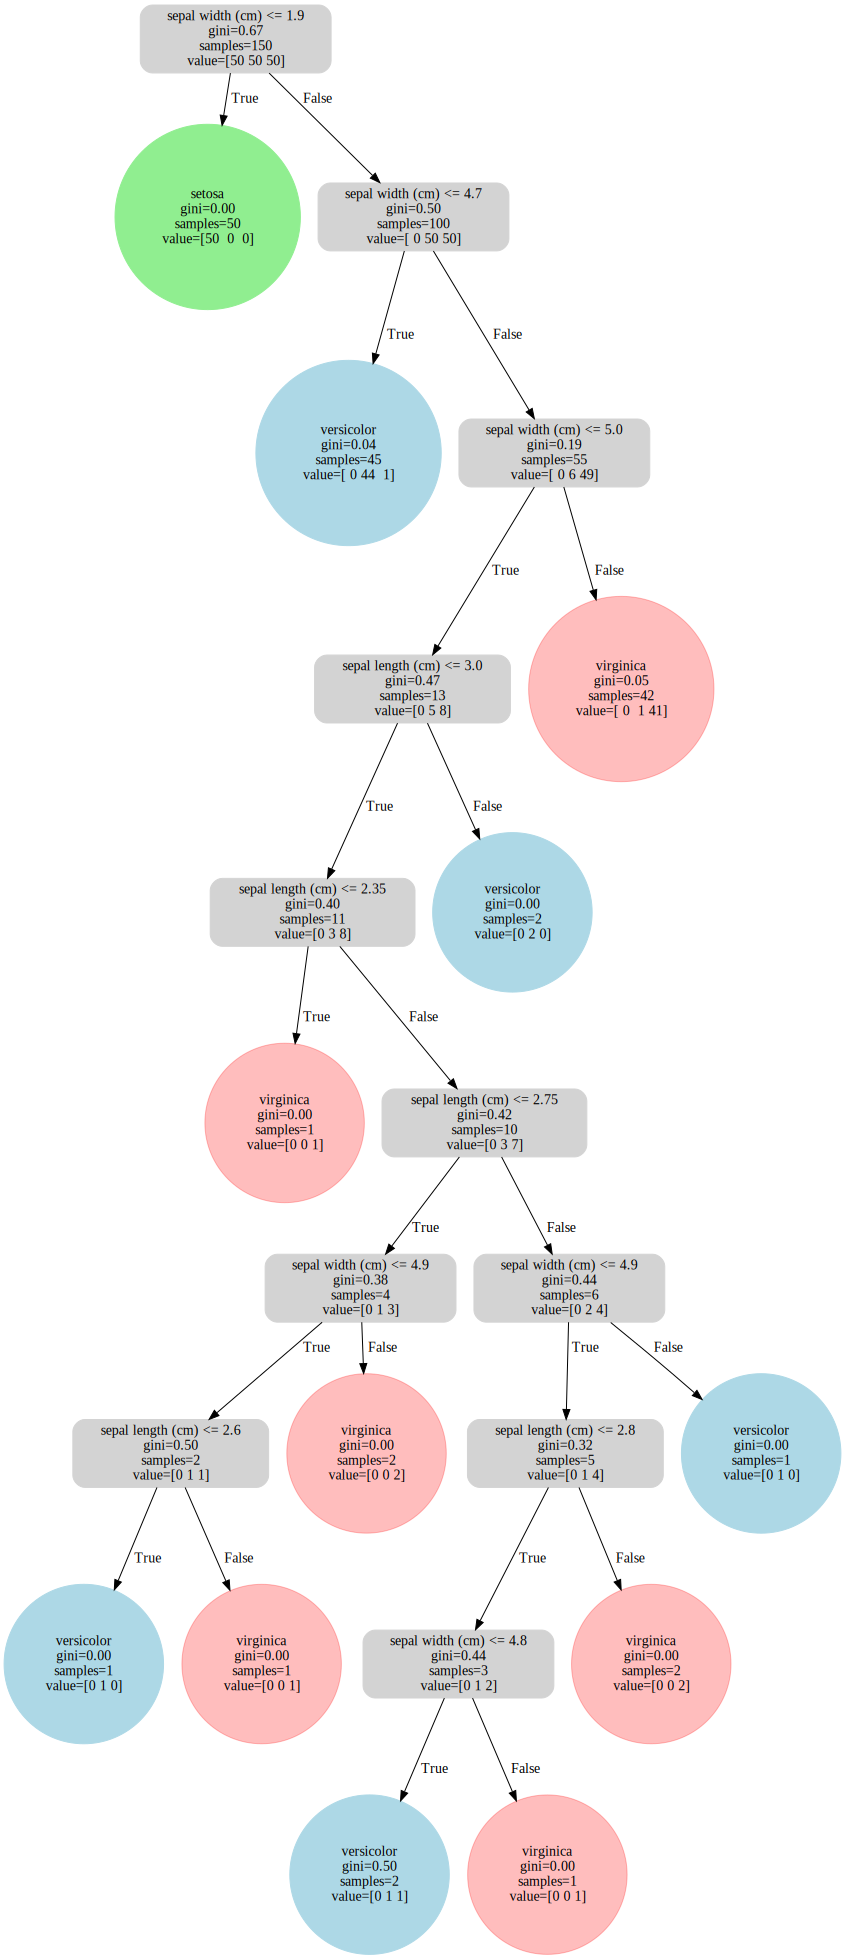

In [233]:
decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, cart=True, fmt=True, alpha=0.1)
G = graphviz.Digraph()
decision_tree.plot_tree(G)
G

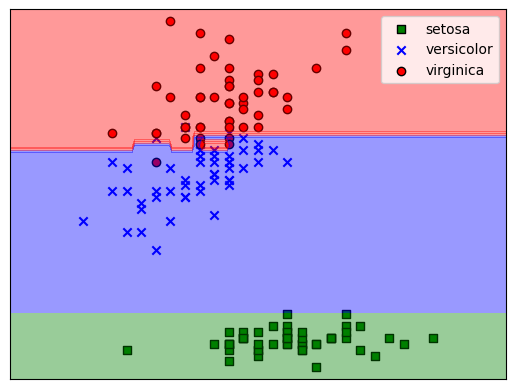

In [234]:
ax = plt.subplot()
ax = plt.subplot()
ax.set(xticks=[], yticks=[])
markers = ('s', 'x', 'o')
colors = ("green", "blue", "red")
for cl, m, c in zip(np.unique(y), markers, colors):
    edgecolors = 'k'
    if m == 'x':
        edgecolors = None
    ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=1, c=c, 
               edgecolors=edgecolors, marker=m, label=iris.target_names[cl])
ax.legend()
x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_min, x1_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 200), np.linspace(x1_min, x1_max))
xy = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([decision_tree.predict(feature)[0] for feature in np.c_[xx.ravel(), yy.ravel()]]).reshape(xx.shape)
cm = ListedColormap(colors)
ax.contourf(xx, yy, Z, cmap=cm, alpha=0.4)
plt.show()

#### 后剪枝
预剪枝是在划分数据集之前判断节点的基尼系数再决定是否要划分，后剪枝则相反，后剪枝在划分完数据集之后，判断此次划分得到的加权基尼系数和节点本身基尼系数的差值，如果差值的绝对值小于某个预设的值，说明此次划分得到的收益不大，就无需划分了，这个参数就是$\beta$。

比如当前基尼系数是$a$，划分后得到两个数据集$D_1$和$D_2$，加权基尼系数就是

$$b=\frac{||D_1||}{||D||} \times Gini_{D_1} + \frac{||D_2||}{||D||} \times Gini_{D_2}$$

如果

$$|b - a| \lt \beta$$

那么此次划分得到的收益不大，就停止此次划分。

在`DecisionTree`的`__init__`方法中添加`beta`参数，决策树只有三层，并且分支树只有4个了。

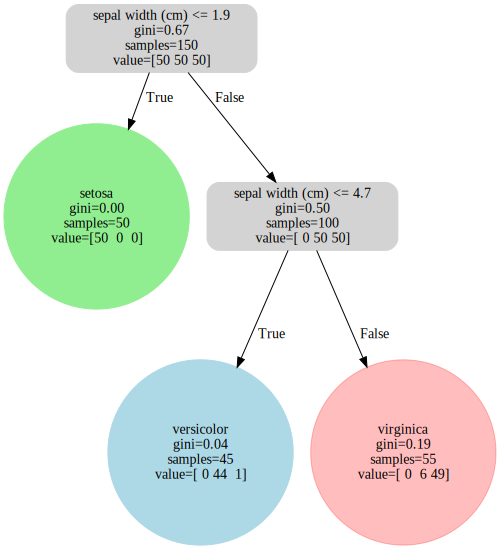

In [235]:
decision_tree = DecisionTree(X, y, get_feature_name, get_feature_value_name, 
                             get_target_name, get_target_color, get_target, cart=True, fmt=True, beta=0.1)
G = graphviz.Digraph()
decision_tree.plot_tree(G)
G

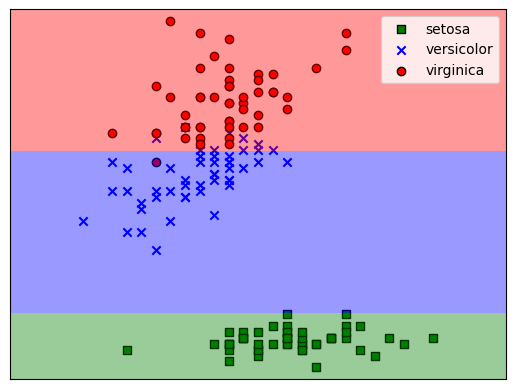

In [236]:
ax = plt.subplot()
ax = plt.subplot()
ax.set(xticks=[], yticks=[])
markers = ('s', 'x', 'o')
colors = ("green", "blue", "red")
for cl, m, c in zip(np.unique(y), markers, colors):
    edgecolors = 'k'
    if m == 'x':
        edgecolors = None
    ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=1, c=c, 
               edgecolors=edgecolors, marker=m, label=iris.target_names[cl])
ax.legend()
x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_min, x1_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 200), np.linspace(x1_min, x1_max))
xy = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([decision_tree.predict(feature)[0] for feature in np.c_[xx.ravel(), yy.ravel()]]).reshape(xx.shape)
cm = ListedColormap(colors)
ax.contourf(xx, yy, Z, cmap=cm, alpha=0.4)
plt.show()

预剪枝一旦发现节点的基尼系数小于$\alpha$就停止划分，但是可能后面会有更好的划分，比如遇到更大的基尼系数，而后剪枝不会有这个问题，因此在实际使用中，后剪枝更常见，但是后剪枝会有数据集的划分，计算量会更大。

## 回归树
回归树(Regression Tree)基本原理和决策树一致，也是通过CART算法将数据集划分，唯一的不同是评价划分好坏的逻辑不一样。

决策树使用基尼函数评价划分的好坏，而回归树则使用另外一种方法来评判。

通过CART算法按照某一维特征将数据集$D$划分成两部分，记为$D_1$，$D_2$，通过如下公式作为评价标准

$$err=\sum_{i=1}^{2}\sum_{j=1}^{j=||D_i||}(y_{ij}-\bar{y_i})^2$$

其中$y_{ij}$表述划分的子集$D_i$中第$j$个样本的标签值，$\bar{y_i}$是子集$D_i$所有样本标签值的平均值。

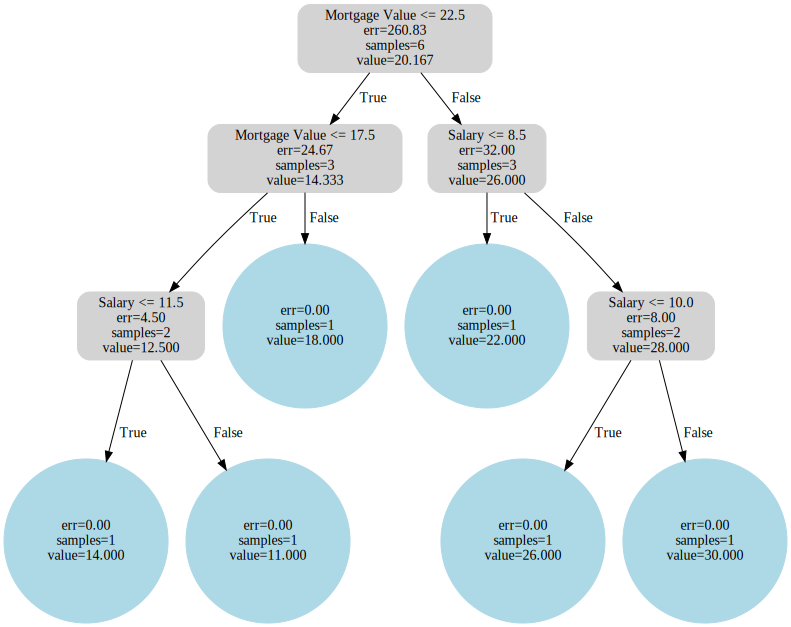

In [237]:
class RegressionTree(DecisionTree):
    def __init__(self, X: np.ndarray, y: np.ndarray, feature_names, feature_value_names, 
                 target_names, target_colors, target):
        super().__init__(X, y, feature_names, feature_value_names, 
                         target_names, target_colors, target, 
                         cart=True, fmt=True, regression=True)

    def _gini(self, y: np.ndarray):
        ey = np.mean(y)
        return np.sum(np.power(y - ey, 2))
    
X = np.array([[13, 10], [10, 15], [12, 20], [8, 25], [9, 30], [11, 40]])
y = np.array([11, 14, 18, 22, 26, 30])
feature_names = np.array(["Salary", "Mortgage Value"])

def get_feature_name(feature, **kwargs):
    feat_val = kwargs.pop("feat")
    return f"{feature_names[feature]} \<= {feat_val}"

def get_target_name(y: np.ndarray, **kwargs):
    return r"{:.2f}".format(np.mean(y))

def get_target_color(y: np.ndarray, **kwargs):
    return "lightblue"

def get_target(y: np.ndarray):
    return np.mean(y)

regression_tree = RegressionTree(X, y, get_feature_name, get_feature_value_name,
                                 get_target_name, get_target_color, get_target)
G = graphviz.Digraph()
regression_tree.plot_tree(G)
G

In [238]:
feature = np.array([12, 7])
print(f"{feature} is {regression_tree.predict(feature)}")

[12  7] is (11.0, '11.00')


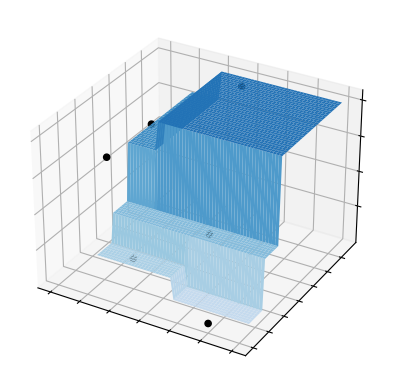

In [239]:
ax = plt.subplot(projection='3d')
ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])
ax.scatter(X[:, 0], X[:, 1], y, alpha=1, color='k')
x0_min, x0_max = X[:, 0].min() + 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() + 3, X[:, 1].max() + 3
xx, yy = np.meshgrid(np.linspace(x0_min, x0_max), np.linspace(x1_min, x1_max))
Z = np.array([regression_tree.predict(feat)[0] for feat in np.c_[xx.ravel(), yy.ravel()]]).reshape(xx.shape)
ax.plot_surface(xx, yy, Z, vmin=Z.min() - 10, vmax=Z.max() + 10, cmap=plt_cm.Blues)
plt.show()